In [1]:
# Installing the dependencies in our virtual environment.
# Please note that we will be using Tensorflow 2.4.1 which requires python 3.6 - 3.8. So, here we use python 3.7.3
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
import uuid
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
tf.test.is_built_with_cuda()

True

In [7]:
# Setup Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [8]:
# Now, let's make the above directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

In [9]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
# !tar -xf lfw.tgz

In [10]:
# Move LFW Images to the following repository data/negative
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [11]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()
#     cv2.imshow('Image Collection', frame)
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()
# plt.imshow(frame[115:115+250, 195:195+250, :])
# print(frame.shape)
# print(frame[115:115+250, 195:195+250, :].shape)

In [12]:
# # Establish a connection to the webcam
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()
    
#     # Cut down the frame to 250x250px
#     frame = frame[115:115+250, 195:195+250, :]
    
#     # Collect Anchors
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         # Create the unique file path
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Writeout anchor image
#         cv2.imwrite(imgname, frame)
        
#     # Collect Positives
#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         # Create the unique file path
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         # Writeout positive image
#         cv2.imwrite(imgname, frame)
        
#     cv2.imshow('Image Collection', frame)
        
#     # Breaking out
#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
    
# # Release the webcam
# cap.release()
# # Close the image show frame
# cv2.destroyAllWindows()

In [13]:
# Get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(780)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(780)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(780)

In [14]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1
    img = img / 255.0
    
    # Return image
    return img

In [15]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [16]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [17]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 1024)

In [18]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [19]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [20]:
# Build Embedding Layer

def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # First Block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    # Second Block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    # Third Block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [21]:
embedding = make_embedding()

In [22]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [23]:
# Siamese L1 Distance class

class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [24]:
siamese_layer = L1Dist()

In [25]:
# Make Siamese Model

def make_siamese_model():
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [26]:
siamese_model = make_siamese_model()

In [27]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

In [28]:
# Training

# Setup Loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [29]:
opt = tf.keras.optimizers.Adam(1e-4)

In [30]:
# Establish Checkpoints

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [31]:
# Build Train Step Function

@tf.function
def train_step(batch):
    
    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        x = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(x, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

In [32]:
# Build Training Loop

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
            
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

In [33]:
# # Train the model
# train(train_data, 50)

In [34]:
# Evaluate model
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [35]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [36]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[0.49910396],
       [0.49940306],
       [0.49972692],
       [0.49933213],
       [0.5005423 ],
       [0.49952623],
       [0.4984005 ],
       [0.49935257],
       [0.49906737],
       [0.4980689 ],
       [0.49965918],
       [0.4984783 ],
       [0.49972174],
       [0.497914  ],
       [0.4979331 ],
       [0.49809766]], dtype=float32)

In [37]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [38]:
y_true

array([0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

In [39]:
# Calculate metrics
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.0

In [40]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.0

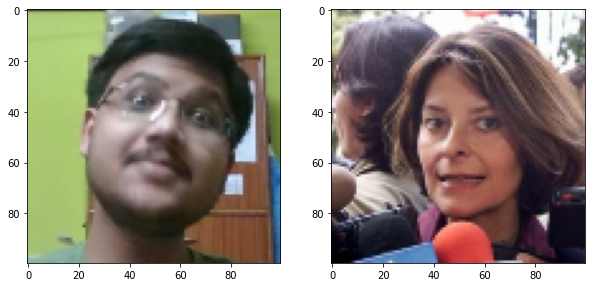

In [41]:
# Viz Results
# Set plot size
plt.figure(figsize=(10, 8))

# Set first subplot
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1, 2, 2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [42]:
# # Save Model

# # Save weights
# siamese_model.save('siamesemodel.h5')

In [43]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [44]:
# Make predictions with reloaded model
y_hat = model.predict([test_input, test_val])

In [45]:
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0]

In [46]:
print(y_true)

[0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.]


In [47]:
# Calculate metrics
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [48]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [49]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [50]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir('application_data/verification_images'):
        input_img = preprocess('application_data/input_image/input_image.jpg')
        validation_img = preprocess(os.path.join('application_data/verification_images', image))
        
        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)
        
    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold) # Number of positive predictions
    
    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir('application_data/verification_images')) # Predicted Positive / no. of verification_images
    verified = verification > verification_threshold
    
    return results, verified

In [51]:
# def verify(model, detection_threshold, verification_threshold):
#     # Build results array
#     results = []
#     for image in os.listdir(os.path.join('application_data', 'verification_images')):
#         input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
#         validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
#         # Make Predictions
#         result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
#         results.append(result)
        
#     # Detection Threshold: Metric above which a prediction is considered positive
#     detection = np.sum(np.array(results) > detection_threshold) # Number of positive predictions
    
#     # Verification Threshold: Proportion of positive predictions / total positive samples
#     verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) # Predicted Positive / no. of verification_images
#     verified = verification > verification_threshold
    
#     return results, verified

In [64]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[115:115+250, 195:195+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite('application_data/input_image/input_image.jpg', frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7vvvvv)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

True
True
True
True
True
True
True
False
True
True
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
True
False
False
True
False
False
True
False
False
True
True
False
True
True
False
False
False
True
True
False
False
False
True
True
True
True
True
False
True
False
False
False
True
True
True
True
True
True
True
True
True
False
False
True
False
False
False
True
False
True
False
False
False
False
False
False
True
True
False
False
False
True
True
True
True
True
True
True
True
True
True
True


In [65]:
results, verified = verify(model, 0.9, 0.7)
np.sum(np.squeeze(results) > 0.9)

49